In [6]:
import os
import librosa
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
# Hàm trích xuất MFCC cùng với delta và delta-delta
def extract_mfcc_with_deltas(audio, sr=16000, n_mfcc=13):
    hop_length = int(0.01 * sr)  # Bước nhảy 10 ms
    win_length = int(0.025 * sr)  # Cửa sổ 25 ms
    
    # Tính toán MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, win_length=win_length, window='hamming')
    
    # Tính toán delta (đạo hàm bậc nhất)
    mfcc_delta = librosa.feature.delta(mfccs)
    
    # Tính toán delta-delta (đạo hàm bậc hai)
    mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
    
    # Gộp MFCCs, delta và delta-delta
    mfcc_combined = np.vstack([mfccs, mfcc_delta, mfcc_delta2])
    
    # Trả về ma trận MFCC đã gộp, mỗi cột là một vector đặc trưng của một khung thời gian
    return mfcc_combined.T  # Chuyển vị để phù hợp với định dạng (time_steps, features)


In [4]:
# Hàm tải dữ liệu từ thư mục
def load_data(data_dir):
    X = []
    y = []
    labels = os.listdir(data_dir)
    
    for label in labels:
        label_dir = os.path.join(data_dir, label)
        for file_name in os.listdir(label_dir):
            if file_name.endswith(".wav"):
                file_path = os.path.join(label_dir, file_name)
                # Tải file âm thanh
                audio, sr = librosa.load(file_path, sr=None)
                features = extract_mfcc_with_deltas(audio, sr)
                
                # Lấy trung bình các đặc trưng qua các khung thời gian để có một vector đặc trưng duy nhất
                feature_mean = np.mean(features, axis=0)
                X.append(feature_mean)
                y.append(label)
    
    return np.array(X), np.array(y)

In [5]:
# Đường dẫn tới dữ liệu huấn luyện và kiểm thử
train_data_dir = r'C:\Users\USER\Downloads\SV_NCKH_audio_event\Train'
test_data_dir = r'C:\Users\USER\Downloads\SV_NCKH_audio_event\Test'

# Tải dữ liệu
X_train, y_train = load_data(train_data_dir)
X_test, y_test = load_data(test_data_dir)

# Encode labels (chuẩn hóa nhãn)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Chuẩn hóa đặc trưng
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [6]:
# Khởi tạo và huấn luyện mô hình Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Huấn luyện mô hình
rf_model.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred = rf_model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

Accuracy: 0.5857
Classification Report:
              precision    recall  f1-score   support

      Sound0       0.52      0.16      0.25        67
      Sound1       0.60      0.07      0.12        44
     Sound10       0.69      0.70      0.70        64
     Sound11       0.62      0.62      0.62        47
     Sound12       1.00      0.14      0.25        14
     Sound13       1.00      1.00      1.00        51
     Sound14       0.39      1.00      0.57        30
     Sound15       1.00      0.50      0.67         2
     Sound16       0.32      0.17      0.22        66
     Sound17       0.36      0.69      0.47        64
     Sound18       0.00      0.00      0.00         8
     Sound19       0.14      0.04      0.07        23
      Sound2       1.00      0.96      0.98        55
     Sound20       0.61      0.98      0.75        46
      Sound3       0.71      1.00      0.83        15
      Sound4       0.57      0.91      0.70        88
      Sound5       0.00      0.00      0.

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1344: Undefin

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:03:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
[[ 7  0 10  2  0  0 29  0 10  2  0  0  0  1  0  4  0  0  2  0  0]
 [ 0  1  0  0  0  0  0  0  0 18  0  1  0 11  0 12  0  0  0  1  0]
 [ 4  0 46  1  0  0  3  0  2  0  0  0  0  0  7  1  0  0  0  0  0]
 [ 1  1  1 31  0  0  0  0  8  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  1  8  0  1  0  1  0  0  0  0  0  0  0]
 [ 2  0  3  2  0 40  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  5 14  0  0  0  0  8 11  0  2  0  4  0 20  0  0  1  0  0]
 [ 0  1  0  0  1  0  0  0  0 40  0  4  0  8  0  8  0  0  0  0  2]
 [ 7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  8  0  3  0  8  0  0  0  0  0  0  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 53  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  4  0  0  0 38  0  2  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0

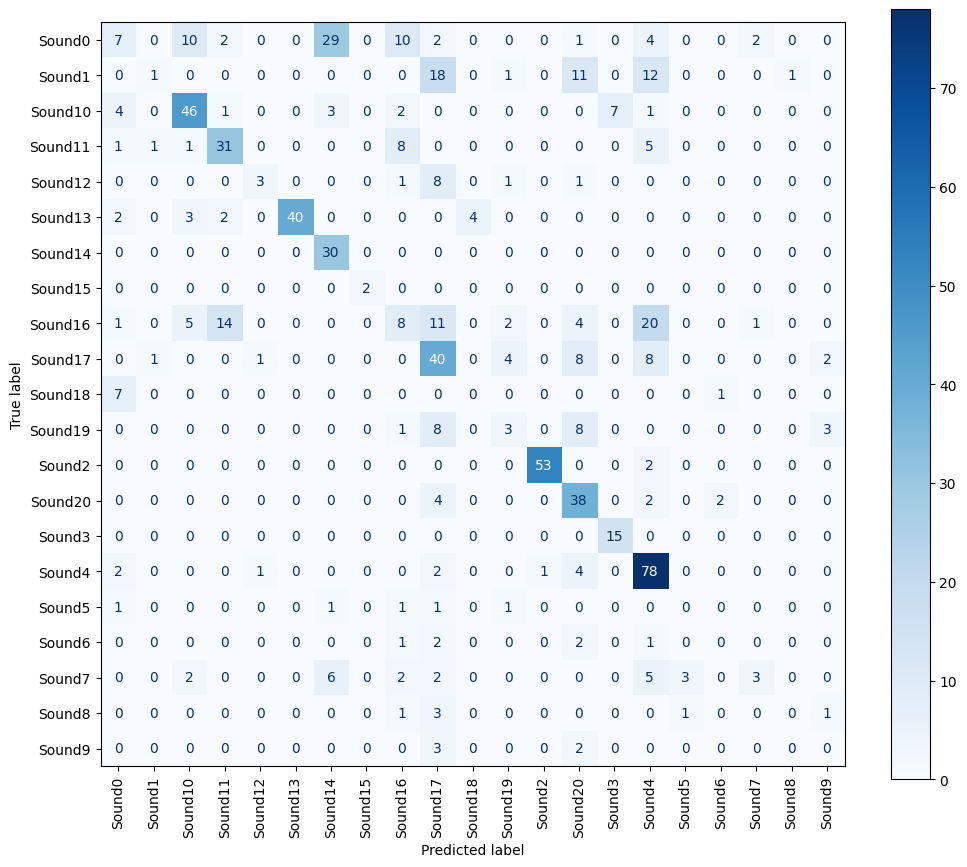

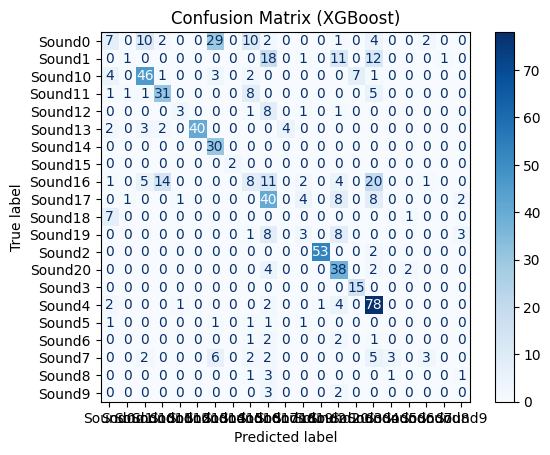

In [ ]:
# 1. Train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)  # Train model

# 2. Predict on test set
y_pred = xgb_model.predict(X_test)  # Predict test labels

# 3. Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# 4. Visualize confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=90)
plt.title("Confusion Matrix (XGBoost)")
plt.show()